In [30]:
import os
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import numpy as np
import math

In [88]:
def exponential_model(x,a,b,c):
    return np.exp(b*(x-c))

def exponential_model_log(x,a,b,c):
    return np.log10(np.exp(b*(x-c)))

def get_exp_fit(country):
    if country == "Iceland":
        return (0,0)
    y = df.loc[country].values
    y = np.trim_zeros(y)
    
    ones = 0
    for i in y:
        if (i == 1):
            ones += 1
            
    if ones > 3:
        y = y[ones-2:-1]
        
    if y.size < 7:
        return (0,0)
    
    x = list(range(0,y.size,1))
    ylogged = [math.log(z,10) for z in y]
    exp_fit = curve_fit(exponential_model_log,x,ylogged,p0=[1,0.25,1])
    
    ymodel = []
    var = 0
    for i in x:
        var += ((exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) - y[i]) / exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]))**2
        ymodel.append(exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]))
    var /= y.size
    stddev = np.sqrt(var)
    
    return (exp_fit[0][1], stddev, x, y, ymodel)

In [89]:
csv = "../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"

df = pd.read_csv(csv,index_col="Country/Region")
del df['Lat']
del df['Long']
del df['Province/State']

df = df.groupby(['Country/Region']).sum()

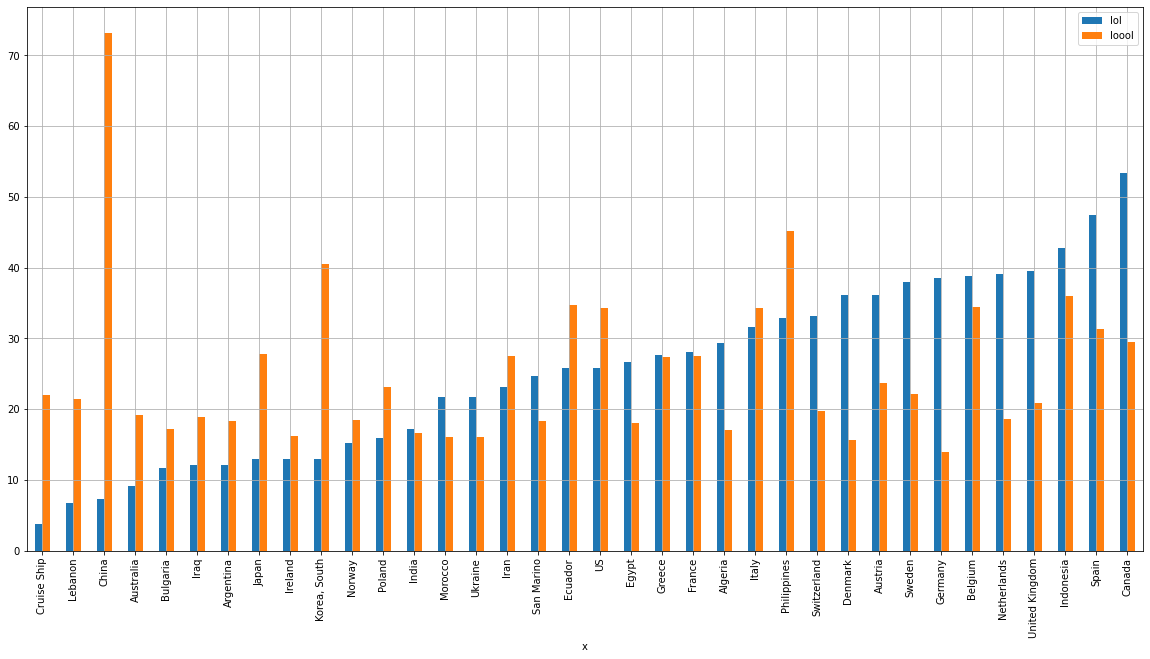

In [94]:
result = dict()
for i, j in df.iterrows():
    a = get_exp_fit(i)
    if a[0] != 0:
        result[i] = a

sorted_result = sorted(result.items(), key=lambda kv: kv[1][0])

labels = []
values = []
stddevs = []
for i in sorted_result:
    labels.append(i[0])
    values.append(((np.exp(i[1][0]))-1)*100)
    stddevs.append(i[1][1]*100)

df2 = pd.DataFrame({'x' : labels, 'y' : values, 'stderr' : stddevs})
df2.set_index("x",drop=True,inplace=True)
ax = df2.plot(kind="bar")
ax.legend(["Modelled daily growth of total deaths [%]", "Standard deviation of  from [%]"])

plt.xticks(rotation=90)
plt.grid()
plt.rcParams["figure.figsize"] = (20,10)

plt.show()

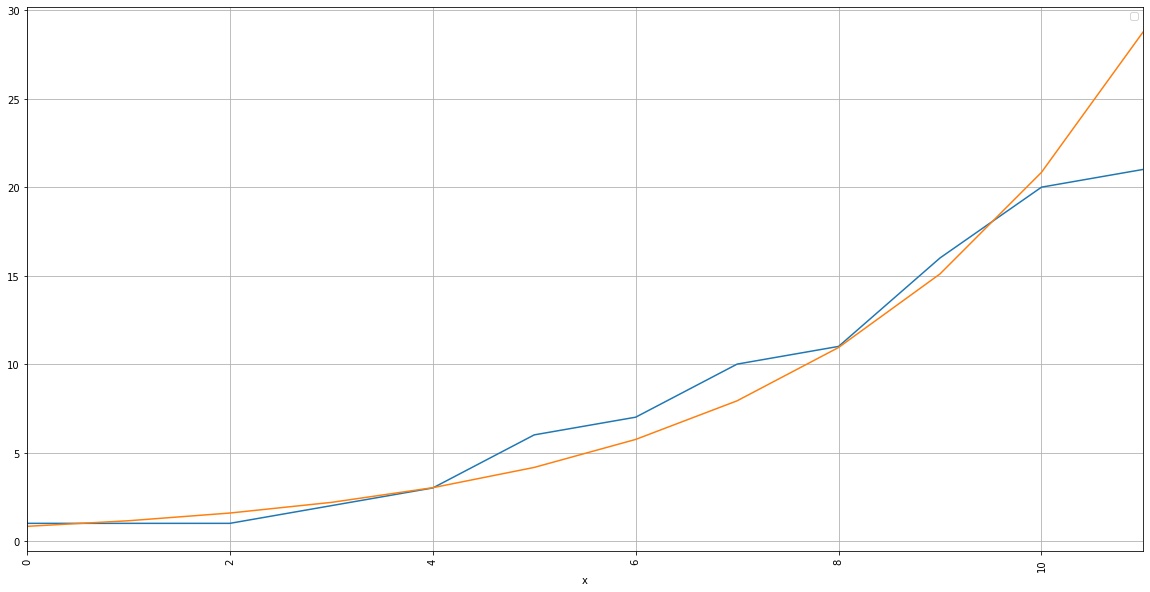

In [92]:
fit = get_exp_fit("Sweden")

labels = []
values = []
model = []
for i in fit[2]:
    labels.append(fit[2][i])
    values.append(fit[3][i])
    model.append(fit[4][i])

df2 = pd.DataFrame({'x' : labels, 'y' : values, 'ymodel' : model})
df2.set_index("x",drop=True,inplace=True)
ax = df2.plot()
ax.legend([])

plt.xticks(rotation=90)
plt.grid()
#plt.yscale("log")
plt.rcParams["figure.figsize"] = (20,10)

plt.show()